In [1]:
import xarray as xr

# To deal with NASA earthdata login
import netrc 
import fsspec
import aiohttp

In [2]:
# Authentication requiring local .netrc
# Or else:  ReferenceNotReachable: Reference "lat/0" failed to fetch target ['https://data.gesdisc.earthdata.nasa.gov/data/MERRA2/M2SDNXSLV.5.12.4/2024/01/MERRA2_400.statD_2d_slv_Nx.20240101.nc4', 25317, 76]
(username, account, password) = netrc.netrc().authenticators("urs.earthdata.nasa.gov")
fsspec.config.conf['https'] = dict(client_kwargs={'auth': aiohttp.BasicAuth(username, password)})

In [3]:
vref = 'https://raw.githubusercontent.com/scottyhq/virtualizarr-merra2/main/test-remote.json'
ds = xr.open_dataset(vref, engine='kerchunk', chunks={})
ds

<xarray.Dataset> Size: 839kB
Dimensions:   (time: 1, lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 5kB -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 8B 2024-01-01T12:00:00
Data variables:
    TPRECMAX  (time, lat, lon) float32 832kB dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
Attributes: (12/31)
    Comment:                           GMAO filename: d5124_m2_jan10.statD_2d...
    Contact:                           http://gmao.gsfc.nasa.gov
    Conventions:                       CF-1
    DataResolution:                    0.5 x 0.625
    EasternmostLongitude:              179.375
    Filename:                          MERRA2_400.statD_2d_slv_Nx.20240101.nc4
    ...                                ...
    TemporalRange:                     1980-01-01 -> 2016-12-31
    Title:                             MERRA2 statD_2d_slv_Nx: 2d,Daily,Aggre...
    VersionID:                         5.12.4
    WesternmostLongitude:              -180.0
    identifier_product_doi:            10.5067/9SC1VNTWGWV3
    identifier_product_doi_authority:  http://dx.doi.org/

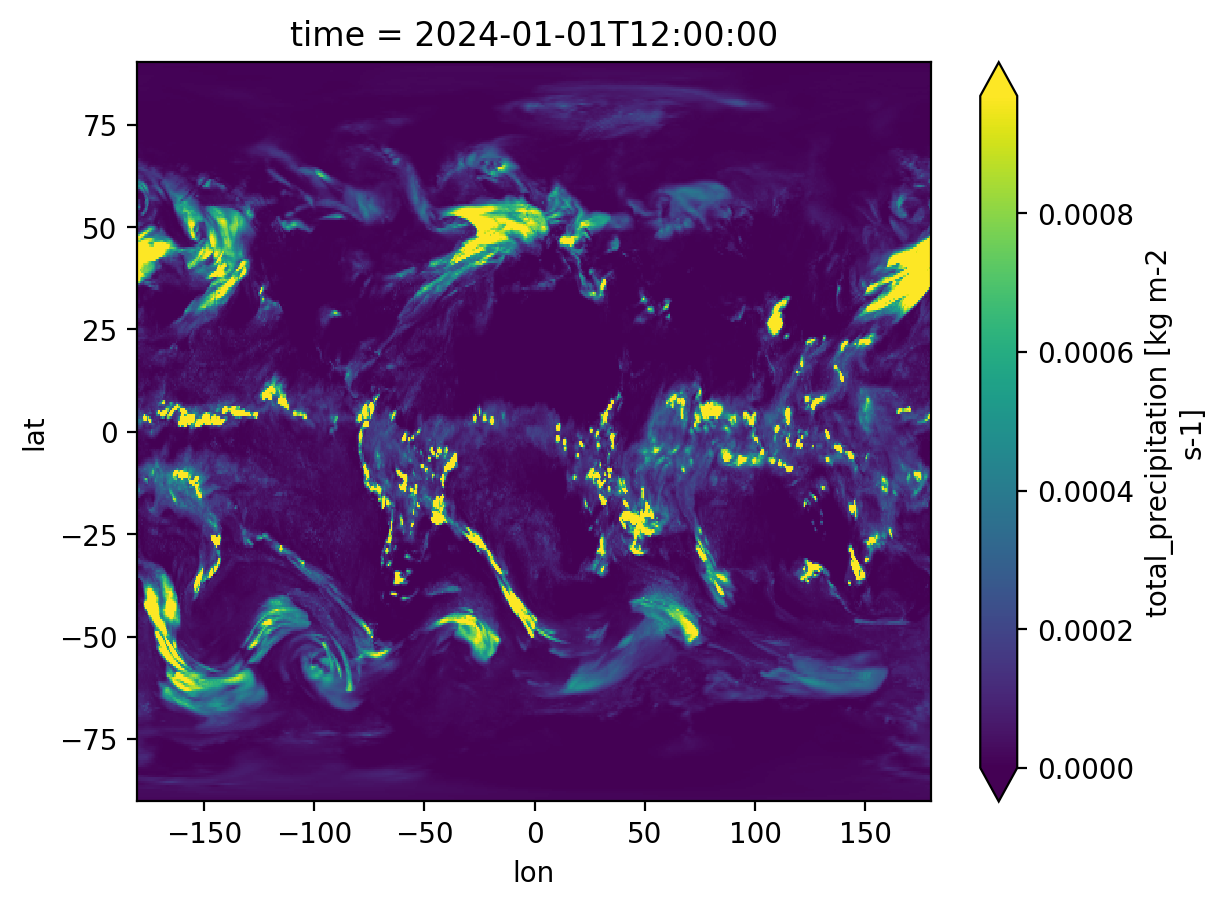

In [4]:
ds.TPRECMAX.isel(time=0).plot(robust=True)

In [5]:
vref = 'https://raw.githubusercontent.com/scottyhq/virtualizarr-merra2/main/M2SDNXSLV.json'
#ds = xr.open_dataset(vref, engine='kerchunk', chunks={}) # match native chunking (chunk~50kB best for local disk access)
#ds = xr.open_dataset(vref, engine='kerchunk', chunks=dict(time=-1)) # collapse per-file time chunks (chunk~6MB)
ds = xr.open_dataset(vref, engine='kerchunk', chunks="auto") # optimize for dask (chunk~100MB better for network transfer)
ds

<xarray.Dataset> Size: 507MB
Dimensions:     (time: 122, lat: 361, lon: 576)
Coordinates:
  * lat         (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * lon         (lon) float64 5kB -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * time        (time) datetime64[ns] 976B 2024-01-01T12:00:00 ... 2024-05-01...
Data variables:
    HOURNORAIN  (time, lat, lon) float32 101MB dask.array<chunksize=(122, 361, 576), meta=np.ndarray>
    T2MMAX      (time, lat, lon) float32 101MB dask.array<chunksize=(122, 361, 576), meta=np.ndarray>
    T2MMEAN     (time, lat, lon) float32 101MB dask.array<chunksize=(122, 361, 576), meta=np.ndarray>
    T2MMIN      (time, lat, lon) float32 101MB dask.array<chunksize=(122, 361, 576), meta=np.ndarray>
    TPRECMAX    (time, lat, lon) float32 101MB dask.array<chunksize=(122, 361, 576), meta=np.ndarray>
Attributes: (12/31)
    Comment:                           GMAO filename: d5124_m2_jan10.statD_2d...
    Contact:                           http://gmao.gsfc.nasa.gov
    Conventions:                       CF-1
    DataResolution:                    0.5 x 0.625
    EasternmostLongitude:              179.375
    Filename:                          MERRA2_400.statD_2d_slv_Nx.20240101.nc4
    ...                                ...
    TemporalRange:                     1980-01-01 -> 2016-12-31
    Title:                             MERRA2 statD_2d_slv_Nx: 2d,Daily,Aggre...
    VersionID:                         5.12.4
    WesternmostLongitude:              -180.0
    identifier_product_doi:            10.5067/9SC1VNTWGWV3
    identifier_product_doi_authority:  http://dx.doi.org/

In [6]:
ts = ds.TPRECMAX.isel(lon=80,lat=30).compute() #chunksize=(1, 91, 144) 4.6s, 4.6s : chunksize=(122, 91, 144) 3.1s, 2s, 0.9s, 1.4s : chunksize=(122, 361, 576) 1.8s, 1.6s, 1.6s... caching?

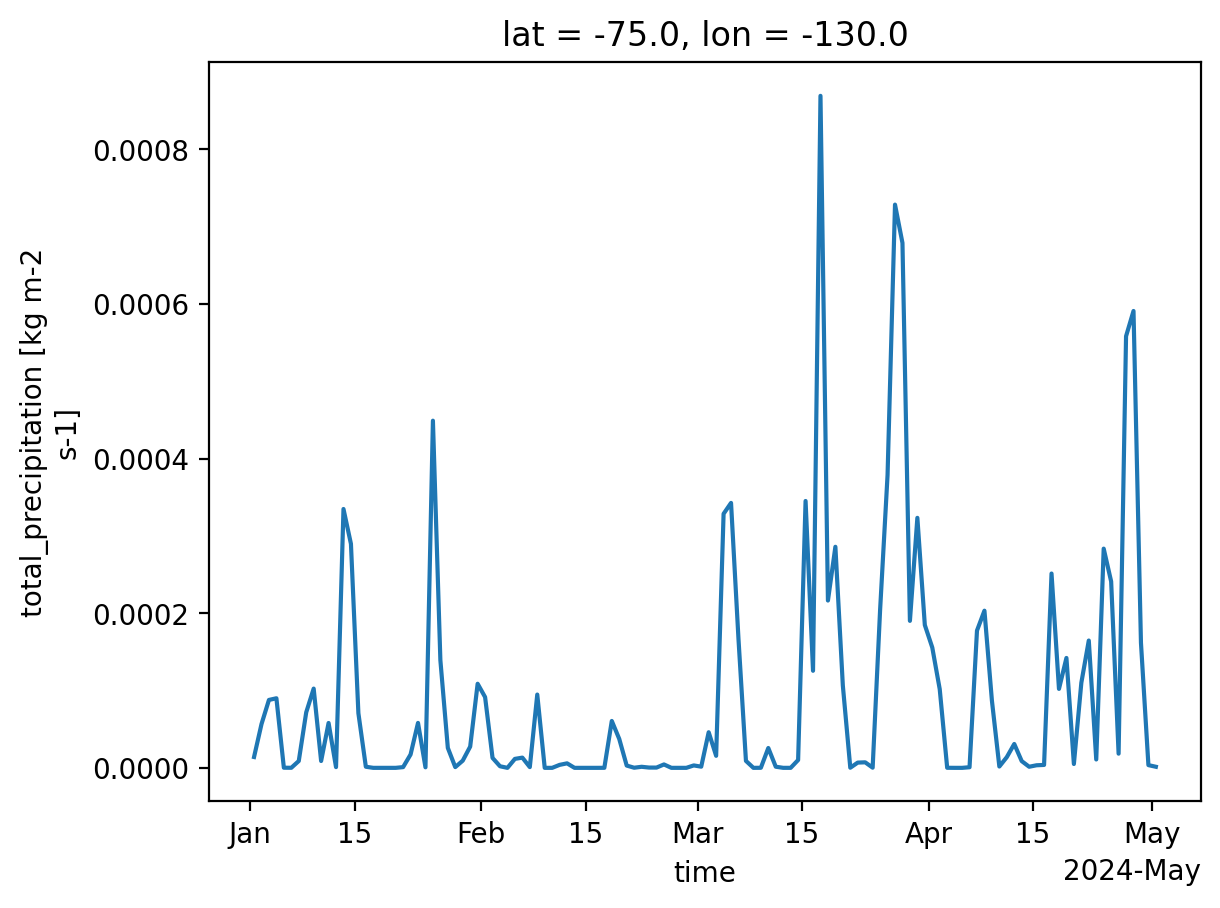

In [7]:
ts.plot();

CPU times: user 637 ms, sys: 144 ms, total: 781 ms
Wall time: 3.55 s


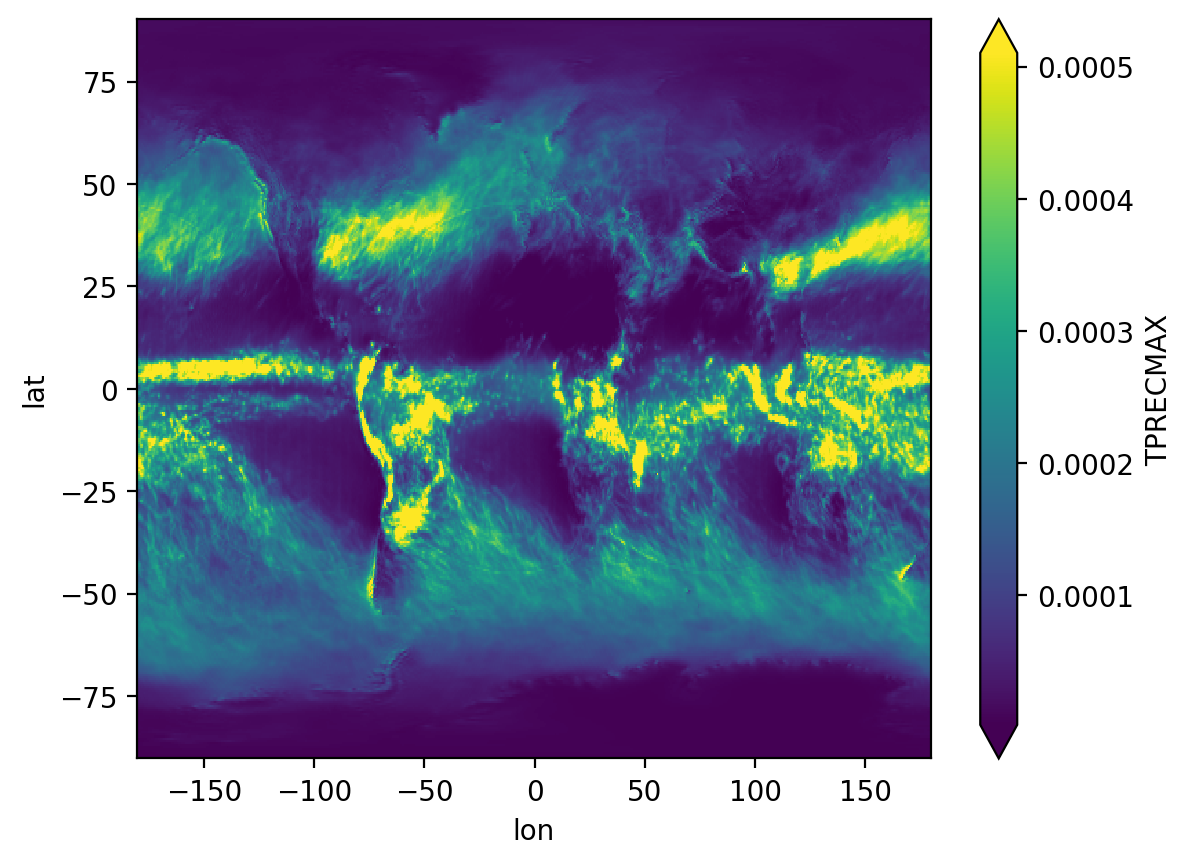

In [8]:
%%time
ds.TPRECMAX.mean(dim='time').compute().plot.imshow(robust=True) #chunksize=(1, 91, 144), 45.7sERROR, 65s : chunksize=(122, 91, 144), 8s : chunksize=(122, 361, 576) 2.5s, 3.7s!